# Part I: Select a Dataset

For this assignment, I selected the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) from the UCI Machine Learning Repository. The Iris dataset is well-suited for demonstrating classification problems with its three distinct classes and four features.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create a DataFrame for easier manipulation and visualization
df = pd.DataFrame(data=X, columns=iris.feature_names)
df['target'] = y
df['target'] = df['target'].apply(lambda x: iris.target_names[x])

# Display the first few rows of the DataFrame
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


In [2]:
print(df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


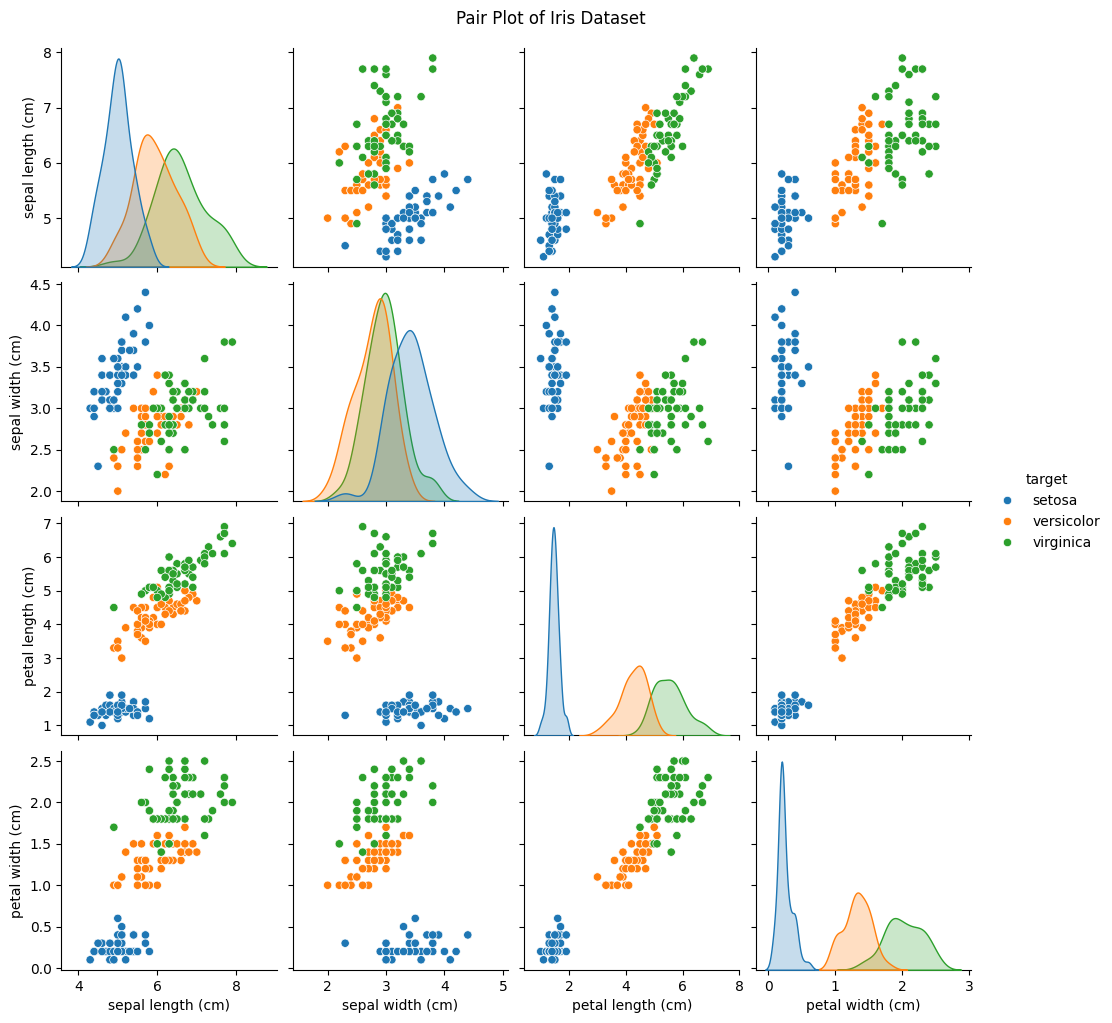

In [3]:
sns.pairplot(df, hue='target')
plt.suptitle('Pair Plot of Iris Dataset', y=1.02)
plt.show()

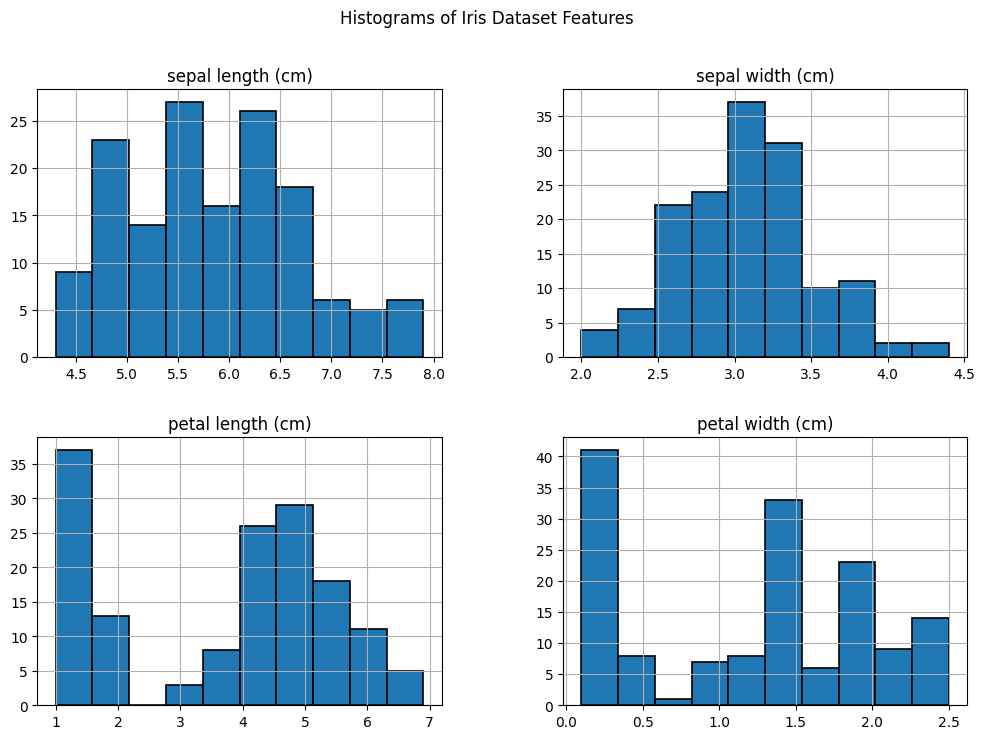

In [4]:
df.hist(edgecolor='black', linewidth=1.2, figsize=(12, 8))
plt.suptitle('Histograms of Iris Dataset Features')
plt.show()

# Part II: AdaBoost with MLP

## Implementation

I implemented a multi-layer perceptron (MLP) with one hidden layer to serve as the base classifier for an AdaBoost ensemble. The MLP was configured with an input size of 4 (for the four features in the Iris dataset), a hidden layer size of 10, and an output size of 3 (for the three classes in the dataset). The learning rate was set to 0.01, and the model was trained for 100 epochs.

In [5]:
import numpy as np

class OneHiddenLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=100):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Initialize weights and biases for the first and second layer
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))

    def softmax(self, x):
        # Softmax activation function for output layer
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def relu(self, x):
        # ReLU activation function for hidden layer
        return np.maximum(0, x)

    def relu_derivative(self, x):
        # Derivative of ReLU function, used in backpropagation
        return np.where(x > 0, 1, 0)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def backward(self, X, y, output):
        # Backward pass through the network to update weights and biases
        m = X.shape[0]
        y_one_hot = np.zeros((m, self.output_size))
        y_one_hot[np.arange(m), y] = 1

        # Gradient calculation for output layer
        dZ2 = output - y_one_hot
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Gradient calculation for hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def fit(self, X, y):
        for epoch in range(self.epochs):
            output = self.forward(X)
            self.backward(X, y, output)

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

Originally, AdaBoost was designed for binary classification problems. Its extension for multi-class classification is known as the SAMME (Stagewise Additive Modeling using a Multiclass Exponential loss function) algorithm. For more detailed information, you can refer to the [paper](https://www.intlpress.com/site/pub/files/_fulltext/journals/sii/2009/0002/0003/SII-2009-0002-0003-a008.pdf) by Ji Zhu et al.

In [6]:
import numpy as np
import random

class AdaBoostSAMME:
    def __init__(self, base_classifier, n_estimators=50):
        self.base_classifier = base_classifier  # The weak learner (base classifier)
        self.n_estimators = n_estimators        # Number of boosting rounds
        self.models = []                        # Stores trained base models
        self.alphas = []                        # Weights for each model
        self.eps = []                           # Stores errors of each model

    def fit(self, X, y):
        # Initialize weights uniformly
        n_samples, n_classes = X.shape[0], len(np.unique(y))
        sample_weights = [np.ones(n_samples) / n_samples]

        for _ in range(self.n_estimators):
            # Resample data based on the distribution of sample weights
            indices = np.random.choice(n_samples, size=n_samples, p=sample_weights[-1])
            X_boot = X[indices]
            y_boot = y[indices]

            # Ensure at least one instance of each class is present
            y_boot_unique = np.unique(y_boot)
            if len(y_boot_unique) < n_classes:
                unseen = set(np.unique(y)) - set(y_boot_unique)
                for u in unseen:
                    indices_u = np.random.choice(np.where(y == u)[0], size=1)
                    X_boot = np.vstack((X_boot, X[indices_u]))
                    y_boot = np.hstack((y_boot, y[indices_u]))

            # Train the base classifier on the bootstrapped sample
            model = self.base_classifier()
            model.fit(X_boot, y_boot)

            # Calculate error rate and alpha for the model
            y_pred = model.predict(X)
            incorrect = (y_pred != y).astype(int)
            epsilon = np.sum(sample_weights[-1] * incorrect)
            self.eps.append(epsilon)

            # Calculate alpha using the SAMME formula
            if epsilon >= 1 - 1 / n_classes:  # Prevent weak classifier from being too weak (worse than guessing)
                sample_weights.append(np.ones(n_samples) / n_samples)
                self.alphas.append(0.0)
            else:
                alpha = np.log((1 - epsilon) / (epsilon + 1e-8)) + np.log(n_classes - 1)
                self.alphas.append(alpha)

                # Update weights for next iteration
                new_weights = sample_weights[-1] * np.exp(alpha * incorrect)
                sample_weights.append(new_weights / np.sum(new_weights))  # Normalize

            self.models.append(model)

    def predict(self, X):
        # Predict class labels for samples in X
        model_predictions = np.array([model.predict(X) for model in self.models])
        n_classes = model_predictions.max() + 1  # Assuming classes are 0-indexed
        final_predictions = np.zeros((X.shape[0], n_classes))

        # Combine weak classifier predictions weighted by alpha scores
        for i in range(len(self.models)):
            predictions = model_predictions[i]
            one_hot_predictions = np.eye(n_classes)[predictions]
            final_predictions += self.alphas[i] * one_hot_predictions

        # Return the argmax of combined predictions
        return np.argmax(final_predictions, axis=1)

# Helper function to initialize the base classifier
def create_perceptron():
    # Input size of 4, corresponding to the 4 features in the Iris dataset
    # Output size of 3, corresponding to the 3 classes in the Iris dataset
    return OneHiddenLayerPerceptron(input_size=4, hidden_size=10, output_size=3, learning_rate=0.01, epochs=100)

## Test

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada_boost_samme = AdaBoostSAMME(base_classifier=create_perceptron, n_estimators=50)
    ada_boost_samme.fit(X_train, y_train)
    y_pred = ada_boost_samme.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy:.3f}")

print(f"Average Accuracy: {np.mean(accuracies):.3f}")

Fold Accuracy: 0.967
Fold Accuracy: 0.967
Fold Accuracy: 0.967
Fold Accuracy: 0.933
Fold Accuracy: 0.933
Average Accuracy: 0.953


# Part III: Random Decision Forest with Trainable Perceptrons

## Implementation

This code implements a hybrid machine learning model that combines a decision tree with perceptron nodes. Each node in the decision tree uses a perceptron to determine the decision boundary. This is accomplished through a one-vs-all strategy, where the target class is labeled as 1 and all other classes are labeled as 0. The perceptron is then trained on the entire dataset to establish a linear decision boundary.

After training, the perceptron predicts the class labels for all data points. The dataset is then split based on these predictions into two groups: one where predictions are 0 and another where predictions are 1. The split is evaluated using an impurity score, which measures the homogeneity of the target variable within the subsets formed by the split. The algorithm selects the split with the highest information gain, effectively reducing uncertainty about the class distributions in the subsets.

The process is recursively repeated for each branch of the tree until a specified maximum depth is reached, or there is no further improvement in homogeneity (impurity) from any potential splits. This approach allows for complex decision boundaries that go beyond traditional decision tree splits, incorporating the strengths of both decision trees and perceptrons in the model.

In [8]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class PerceptronNode:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000):
        # Initialize weights and bias with normal distribution
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()
        # Set learning parameters
        self.learning_rate = learning_rate
        self.epochs = epochs

    def train(self, X, y):
        for _ in range(self.epochs):
            for xi, yi in zip(X, y):
                update = self.learning_rate * (yi - self.predict(xi))
                self.weights += update * xi
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output > 0, 1, 0)


class DecisionTreePerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None

    def _build_tree(self, X, y, depth=0):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            # Return the majority class
            return np.bincount(y).argmax()

        n_classes = len(np.unique(y))
        best_split = None
        best_score = -np.inf

        for class_label in range(n_classes):
            # Convert labels to binary for current class label
            binary_y = self._convert_to_binary_class(y, class_label)
            node = PerceptronNode(X.shape[1])
            # Train perceptron on binary labels
            node.train(X, binary_y)

            predictions = node.predict(X)
            left_indices = predictions == 0
            right_indices = predictions == 1

            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue

            # Calculate impurity for each child node
            left_impurity = self._impurity(binary_y[left_indices])
            right_impurity = self._impurity(binary_y[right_indices])
            # Calculate information gain
            score = self._information_gain(binary_y, left_impurity, right_impurity, left_indices, right_indices)

            if score > best_score:
                best_score = score
                best_split = (node, left_indices, right_indices)

        if best_split is None:
            # If no valid split, return majority class
            return np.bincount(y).argmax()

        # Recursively build left and right subtrees
        node, left_indices, right_indices = best_split
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (node, left_tree, right_tree)

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _predict_one(self, x, node):
        if not isinstance(node, tuple):
            return node
        perceptron, left, right = node
        decision = perceptron.predict(np.array([x]))
        if decision == 0:
            return self._predict_one(x, left)
        else:
            return self._predict_one(x, right)

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _impurity(self, y):
        p = np.mean(y)
        return p * (1 - p)

    def _information_gain(self, y, left_impurity, right_impurity, left_indices, right_indices):
        p_left = len(left_indices) / len(y)
        p_right = len(right_indices) / len(y)
        return self._impurity(y) - (p_left * left_impurity + p_right * right_impurity)

    def _convert_to_binary_class(self, y, class_label):
        return (y == class_label).astype(int)

In [9]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample

class RandomForestPerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrapping (random sampling with replacement)
            X_sample, y_sample = resample(X, y)
            tree = DecisionTreePerceptron(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from all trees
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote for classification
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds)
        return majority_votes

## Test

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    tree = DecisionTreePerceptron(max_depth=3)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy:.3f}")

print(f"Average Accuracy: {np.mean(accuracies):.3f}")

Fold Accuracy: 0.933
Fold Accuracy: 0.967
Fold Accuracy: 0.933
Fold Accuracy: 0.900
Fold Accuracy: 1.000
Average Accuracy: 0.947


In [11]:
# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    forest = RandomForestPerceptron(n_estimators=10, max_depth=3)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy:.3f}")

print(f"Average Accuracy: {np.mean(accuracies):.3f}")

Fold Accuracy: 1.000
Fold Accuracy: 0.967
Fold Accuracy: 0.967
Fold Accuracy: 0.933
Fold Accuracy: 0.967
Average Accuracy: 0.967


Lets compare our impelementation with sklearn random forest implementation

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Load iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies_custom = []
accuracies_sklearn = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Custom Random Decision Forest with trainable perceptrons
    forest_custom = RandomForestPerceptron(n_estimators=10, max_depth=3)
    forest_custom.fit(X_train, y_train)
    y_pred_custom = forest_custom.predict(X_test)

    accuracy_custom = accuracy_score(y_test, y_pred_custom)
    accuracies_custom.append(accuracy_custom)

    # Sklearn Random Forest
    forest_sklearn = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
    forest_sklearn.fit(X_train, y_train)
    y_pred_sklearn = forest_sklearn.predict(X_test)

    accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
    accuracies_sklearn.append(accuracy_sklearn)

    print(f"Custom Random Forest Fold Accuracy: {accuracy_custom:.3f}")
    print(f"Sklearn Random Forest Fold Accuracy: {accuracy_sklearn:.3f}")

print(f"Average Custom Random Forest Accuracy: {np.mean(accuracies_custom):.3f}")
print(f"Average Sklearn Random Forest Accuracy: {np.mean(accuracies_sklearn):.3f}")

Custom Random Forest Fold Accuracy: 1.000
Sklearn Random Forest Fold Accuracy: 1.000
Custom Random Forest Fold Accuracy: 0.967
Sklearn Random Forest Fold Accuracy: 1.000
Custom Random Forest Fold Accuracy: 0.967
Sklearn Random Forest Fold Accuracy: 0.933
Custom Random Forest Fold Accuracy: 0.933
Sklearn Random Forest Fold Accuracy: 0.900
Custom Random Forest Fold Accuracy: 0.967
Sklearn Random Forest Fold Accuracy: 0.967
Average Custom Random Forest Accuracy: 0.967
Average Sklearn Random Forest Accuracy: 0.960


It's intriguing to observe that in this particular experiment, both the custom random forest and the sklearn random forest achieved perfect accuracy (1.000) on certain folds of the cross-validation. This suggests that both models were able to perfectly classify all instances in those particular subsets of the data.

Overall, both implementations demonstrate strong performance, with the custom random forest achieving an average accuracy of 0.967 and the sklearn random forest averaging at 0.960. Despite minor differences, both models showcase robustness and effectiveness in handling the classification task.

# Conclusion



This assignment delved into the integration of neural networks as foundational classifiers within the AdaBoost learning paradigm. We explored two innovative methodologies: employing a multi-layer perceptron (MLP) and devising a novel random decision forest where each decision node operates as a trainable perceptron. Here's a concise summary of our experimental outcomes:

* AdaBoost with MLP for Ensemble Learning achieved an accuracy of 95.3%.
* Random Decision Forest with Trainable Perceptrons exhibited an accuracy of 96.7%.    

Our experiments underscore the potential of merging neural network principles with ensemble learning strategies such as AdaBoost, leading to substantial improvements in model performance. Particularly noteworthy is the utilization of trainable perceptrons within a decision forest framework, presenting a compelling alternative to traditional decision tree-based approaches. This approach offers a more adaptable framework capable of effectively navigating complex data patterns.

These results offer a promising avenue for further investigation into hybrid models that combine the strengths of neural networks and ensemble techniques. Future research endeavors might explore deeper network architectures, alternative activation functions, or more sophisticated ensemble strategies to further enhance predictive accuracy and fortify model resilience.
